In [1]:
import torch
import torch.autograd
import torch.autograd.functional
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

In [19]:
x = torch.linspace(-5., 5., 500)
knode = torch.tensor([0.,5., 10.])
detector =  torch.zeros(2)
observed_flux = torch.tensor([0.56, 0.57, 0.62])
material_A = 0.01
material_B = 0.9
thetas = torch.tensor([0.1,0.0, -0.08]) * np.pi

In [5]:
def level_set(t, node, x, sigma=10.):
    zz02 = (-sigma * torch.log(t)) - (x - node[0]).pow(2)
    zz0 =  torch.sqrt(zz02[zz02 > 0])
    xs = x[zz02 > 0]
    zs = node[1] - zz0
    return xs, zs

In [4]:
def mix_density(state, node):
    return torch.exp(-(state - node[:2]).pow(2).sum(1) / node[2])

In [6]:
def rot(theta):
    n = theta.numel()
    c = torch.cos(theta)
    s = torch.sin(theta)
    return torch.stack([c,-s, s, c]).T.reshape((n,2,2))

In [7]:
def backward_mc(theta, node, npar):
    length1 =  1.0 - 0.2 * torch.rand(npar)
    rot1 = rot(theta)
    step1 = torch.stack([torch.zeros(npar),  length1]).T
    step1 = rot1.matmul(step1.reshape((npar, 2,1))).squeeze()
    state1 = detector + step1

    biasing = torch.randint(0,2, (npar,))
    density = mix_density(state1, node)
    weights = torch.where(biasing > 0, density * material_A, (1 - density) * material_B) / (length1 * 0.5)
    
    length2 =  1.0 - 0.2 * torch.rand(npar)
    rot2 = rot(0.05 * np.pi * (torch.rand(npar) - 0.5))
    step2 = length2.reshape((npar,1)) * step1 / length1.reshape((npar,1))
    step2 = rot2.matmul(step2.reshape((npar,2,1))).squeeze()
    state2 = state1 + step2

    biasing = torch.randint(0,2, (npar,))
    density = mix_density(state2, node)
    weights *= torch.where(biasing > 0, density * material_A, (1 - density) * material_B) / (length1 * 0.5)
    
    return weights, [state1, state2]

In [8]:
def plot_particles(bmc):
    for particle in bmc:
        plt.plot(particle[-1][0].numpy(), particle[-1][1].numpy(), '.C0',markersize=30, alpha=0.6)
        trajectory = torch.cat([detector.reshape(1,2), particle]).T
        plt.plot(trajectory[0].numpy(),trajectory[1].numpy(), 'C0', alpha=0.9)

In [9]:
bmcs = []
for theta in thetas:
    _, bmc = backward_mc(theta, knode, 10)
    bmcs.append(torch.stack(bmc).transpose(0,1))

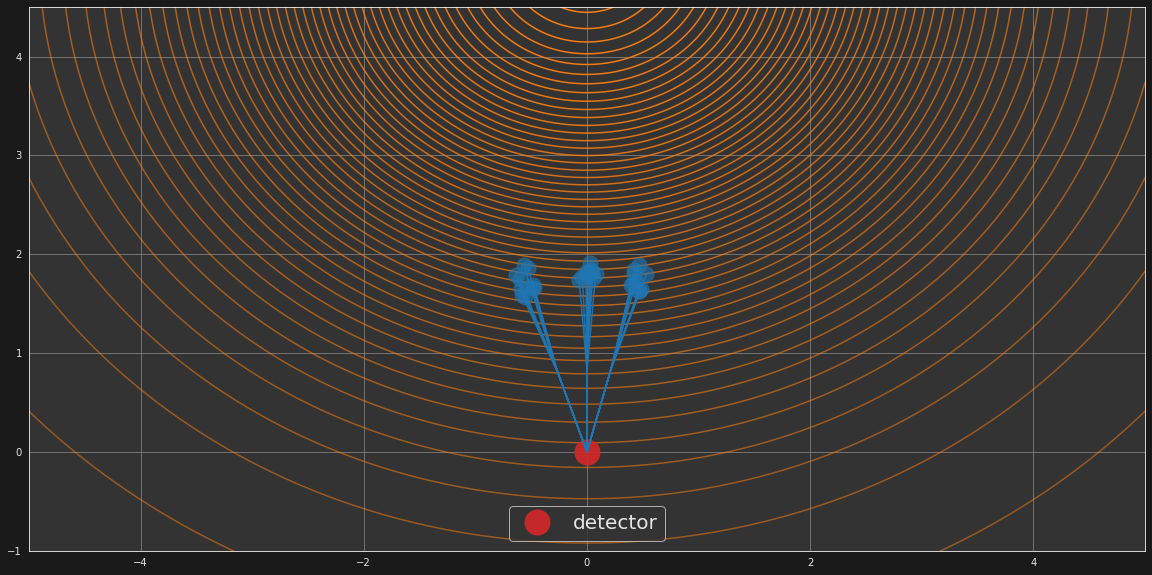

In [636]:
def plot_detector(bmc_data, node_param):
    plt.figure(figsize=(20,10))

    for t in torch.linspace(0.01,0.99, 50):
        xs, zs = level_set(t, node_param, x)
        plt.plot(xs.numpy(), zs.numpy(), 'C1',alpha=.5 + 0.5*t.item())

    plt.plot(detector[0].numpy(), detector[1].numpy(), '.C3',markersize=50, label='detector',alpha=0.9)

    for bmc in bmc_data:
        plot_particles(bmc)

    plt.legend(fontsize=20)
    plt.xlim([-5.,5.]) 
    plt.ylim([-1.,4.5])
    plt.show()
plot_detector(bmcs, knode)

In [11]:
for theta in thetas:
    print(f'Flux at {round(theta.item(),2)}: {backward_mc(theta, knode, 100000)[0].mean()}')

Flux at 0.31: 0.5657855272293091
Flux at 0.0: 0.5386866331100464
Flux at -0.25: 0.555831253528595


In [379]:
def log_prob_flux(node_params):
    log_prob = torch.tensor(0.)
    for i in range(len(thetas)):
        log_prob += (observed_flux[i] - backward_mc(thetas[i], node_params, 100000)[0].mean()).pow(2) / 0.01
    return - log_prob

In [26]:
knodeg = knode.clone().requires_grad_()
pflux = - log_prob_flux(knodeg)
dpflux = torch.autograd.grad(outputs=pflux, inputs=knodeg)[0]
dpflux[0]

tensor([ 0.3822, -5.2667,  0.9424])

In [22]:
knodeg = knode.clone()
hess = torch.autograd.functional.hessian(log_prob_flux, knodeg)
hess

tensor([[  0.9493,  -0.1477,   0.0798],
        [ -0.1477, -48.8989,   8.5541],
        [  0.0798,   8.5541,  -1.4527]])

In [434]:
nu = 0.1
def eval_gradient(node_params):
    nodeg = node_params.detach().requires_grad_()
    pflux = - log_prob_flux(nodeg)
    dpflux = torch.autograd.grad(outputs=pflux, inputs=nodeg)[0]
    return dpflux

In [631]:
inode = torch.tensor([5.,15.,10.]) 
print(- log_prob_flux(inode))
new_knode = inode - nu * eval_gradient(inode)
print(- log_prob_flux(new_knode))
new_knode   

tensor(54.9215)
tensor(55.4641)


tensor([ 5., 15., 10.])

In [632]:
N = 501
gdescent = torch.zeros(N)
for i in range(N):
    g = eval_gradient(new_knode)
    new_knode -= nu * g / (g.norm() + 1e-6)
    gdescent[i] = - log_prob_flux(new_knode)
    if i % 20 == 0:
        print(f'log probability : {gdescent[i]}')
        print(f'node {i} : {new_knode}')

log probability : 54.664283752441406
node 0 : tensor([ 4.9813, 14.9492, 10.0384])
log probability : 54.75041198730469
node 20 : tensor([ 4.4413, 13.4857, 11.0344])
log probability : 55.76957321166992
node 40 : tensor([ 3.8250, 11.8195, 11.9496])
log probability : 55.093101501464844
node 60 : tensor([ 3.1822, 10.0841, 12.7063])
log probability : 47.50227355957031
node 80 : tensor([ 2.5200,  8.2971, 13.3114])
log probability : 13.683513641357422
node 100 : tensor([ 1.8389,  6.4743, 13.7714])
log probability : 0.7026336789131165
node 120 : tensor([ 1.1523,  5.6800, 13.9705])
log probability : 0.525267481803894
node 140 : tensor([ 0.6174,  5.8009, 13.9969])
log probability : 0.3327696919441223
node 160 : tensor([ 0.1552,  5.8468, 14.0108])
log probability : 0.18735021352767944
node 180 : tensor([-0.2341,  5.8404, 14.0176])
log probability : 0.14421816170215607
node 200 : tensor([-0.5090,  5.8225, 14.0186])
log probability : 0.08528656512498856
node 220 : tensor([-0.7303,  5.7925, 14.0182])

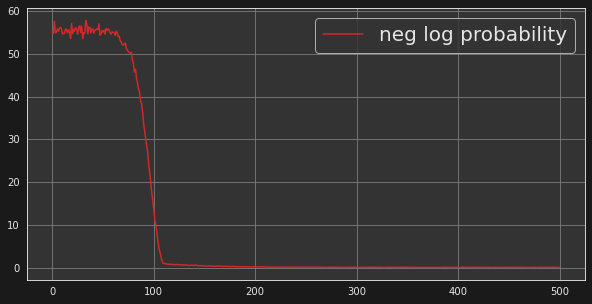

In [634]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(N), gdescent.numpy(), 'C3', label='neg log probability',alpha=0.99)
plt.legend(fontsize=20)
plt.show()

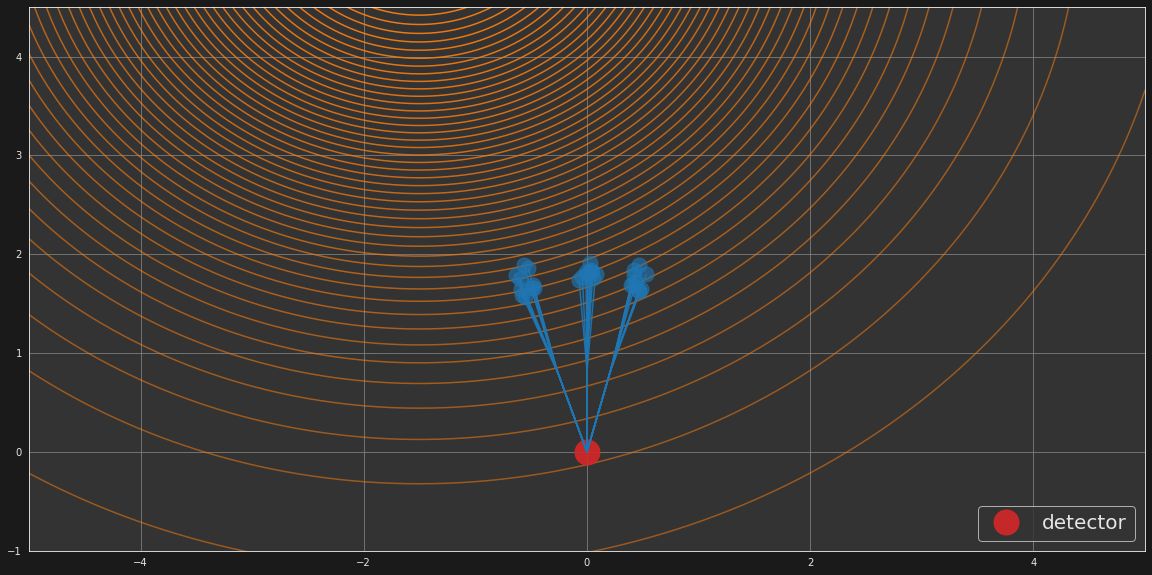

In [637]:
plot_detector(bmcs, new_knode)